## $\kappa$ - Generalised Distribution

$\kappa$ - Generalised exponential:

$$\text{exp}_{\kappa}(x)=(\sqrt{1+\kappa^2x^2} + \kappa x)^{\frac{1}{\kappa}}.$$

$\kappa$ - Generalised logarithm (inverse gen exp):

$$\text{exp}^{-1}_{\kappa}(x)=\text{log}_{\kappa}(x)=\frac{x^{\kappa} - x^{-\kappa}}{2\kappa}.$$

Cumulative Distribution Function (cdf):

$$P(x) = 1 - \text{exp}_{\kappa}(-\beta x^{\alpha}).$$

Probability Density Function (pdf):

$$p(x) = \frac{\alpha\beta x^{\alpha - 1}\text{exp}_{\kappa}(-\beta x^{\alpha})}{\sqrt{1 + \kappa^2\beta^2x^{2\alpha}}}.$$

Inverse cdf, Quantile function:

$$P^{-1}(p) = Q(p) = \frac{\left((1-p)^{-\kappa} - (1-p)^{\kappa}\right)^{\frac{1}{\alpha}}}{2\kappa\beta}.$$

See Clement et al. (2008) for more details. 

## Simulating Stock Prices

Stock prices are assumed to follow a geometric Brownian motion (GBM) with time dependent variance:

$dS_t = \mu S_t dt + \sigma_t S_t dW_t$,

where $S_t$ is the stock price at time $t$, $\mu$ is the drift, $\sigma_t$ is the standard deviation at time $t$, and $W_t$ is a Wiener process (Brownian motion).

Using Ito's Lemma, the analytic solution of the stock price at time $t$ is given by:

$S_t = S_0 \exp\left(\left(\mu + \tfrac{\sigma^2_t}{2}\right)t + \sigma_t W_t\right).$

Therefore, the stock price can be simulated on a discrete time grid $\mathcal{T}=\{\Delta t, 2\Delta t, ..., N\Delta t\}$ with step size $\Delta t$ and length $N$. Thus, the stock price in time $t + \Delta t$ is given by:

$S_{t + \Delta t} = S_{t} \exp\left(\left(\mu + \frac{\sigma^2_t}{2}\right)\Delta t + \sigma_t \Delta W_t\right).$

Let $\Delta W_t = W_{t + \Delta t} - W_t = \varepsilon_t,$

where $\varepsilon_t$ is a random variable distributed according to a $\kappa$-Generalised distribution ($\kappa\text{ - Gen}(\alpha, \beta)$) multiplied by a Rademacher distribution ($\text{Rad}(k)$), which has pdf:

$p_R(k) = \frac{1}{2}\left(\delta(k-1) + \delta(k+1)\right).$

where $\delta(k)$ is the Dirac delta function. Hence, 

$\varepsilon_t \sim \kappa\text{ - Gen}(\alpha, 1)\text{Rad}(k)$

Therefore, the stock price can be simulated discretely as:

$S_{t + \Delta t} = S_{t} \exp\left(\left(\mu + \tfrac{\sigma^2_t}{2}\right)\Delta t + \sigma_t \sqrt{\Delta t} \varepsilon_t \right).$

Let the variance $\sigma^2_t = v_t$, which is assumed to follow an Ornstein–Uhlenbeck process:

$dv_t = \gamma(\theta - v_t)dt + \phi \sqrt{v_t}dW^v_t$,

where $W^v_t$ is a Wiener process which is again assumed to be distributed according to a $\kappa$-Generalised distribution ($\kappa\text{ - Gen}(\alpha, \beta)$) multiplied by a Rademacher distribution ($\text{Rad}(k)$), if $2\gamma\theta > \phi^2$ then $v_t$ is strictly positive $\forall t$ . Hence, it can be simulated on the discrete time grid as:

$v_{t + \Delta t} = v_t + \gamma (\theta - v_t)\Delta t + \phi \sqrt{v_t \Delta t} \varepsilon^v_t.$

References:

Clementi, F., Di Matteo, T., Gallegati, M. and Kaniadakis, G., (2008) The κ-generalized distribution: A new descriptive model for the size distribution of incomes. Physica A: Statistical Mechanics and its Applications, 387(13), pp.3201-3208.

In [1]:
# import packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
# random seed
seed = 75347
# parameters
T = 1
M, N = 10000, 1000
alpha = 1
beta = 1
kappa = 0.2
S0 = 100
mu = 0.1
gamma = 2
theta = 0.2
phi = 0.2
# discrete time grid
times = np.linspace(0, T, N)

### Simulating Random Numbers from PDF

Can use the quantile function $Q(p)$ to simulate random numbers of a given pdf using randomly generated standard uniform random variables as the input to the quantile function.  

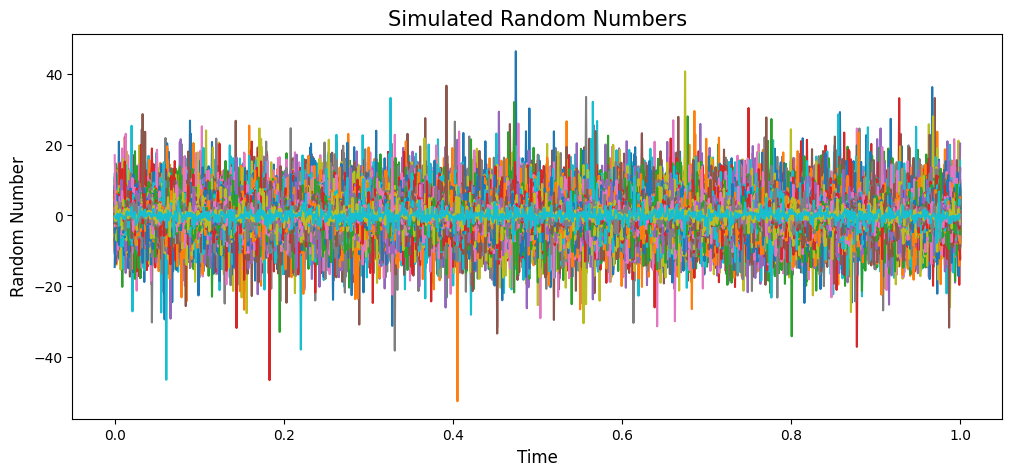

In [36]:
# set random seed for reproducibility 
np.random.seed(seed)

# Quantile function of kappa-gen pdf
def quantile(x, alpha, beta, kappa):
    return (1/beta)*np.power((np.power(1 - x, -kappa) - np.power(1 - x, kappa)) / (2*kappa), 1/alpha)

# uniform random number
u = np.random.rand(M, N)

# kappa-gen distributed random variables
rvs = quantile(u, alpha, beta, kappa)
rvs_v = quantile(u, alpha, beta, kappa)

epsilon = rvs*np.random.choice([1,-1], size=(M, N), p=[0.5, 0.5])
epsilon_v = rvs_v*np.random.choice([1,-1], size=(M, N), p=[0.5, 0.5])

# plot random numbers
plt.figure(figsize=(12,5))
for sim in epsilon:
    plt.plot(times, sim)
plt.title('Simulated Random Numbers', fontsize=15)
plt.ylabel('Random Number', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.show()

In [37]:
# simulate stock prices

def simulate_custom_paths(S0, epsilon, epsilon_v, mu, gamma, theta, phi, T, N, M):
    assert 2*gamma*theta > phi**2, 'expected 2*gamma*theta > phi^2'
    dt = T/N
    Z = np.zeros(shape=(M, N))
    v = np.zeros(shape=(M, N))
    Z[:,0] = np.log(S0)
    v[:,0] = theta
    for i in range(N-1):
        Z[:,i+1] = Z[:,i] + (mu-0.5*v[:,i])*dt + np.sqrt(v[:,i])*np.sqrt(dt)*epsilon[:,i]
        v[:,i+1] = np.abs(v[:,i] + gamma*(theta-v[:,i])*dt + phi*np.sqrt(v[:,i])*np.sqrt(dt)*epsilon_v[:,i])
    S = np.exp(Z)
    return S, v

S, v = simulate_custom_paths(S0, epsilon, epsilon_v, mu, gamma, theta, phi, T, N, M)
S

array([[100.        , 101.50262814, 106.43467323, ..., 205.08528193,
        204.30241294, 213.58166184],
       [100.        ,  99.63134887,  98.3595802 , ...,  44.45140021,
         44.51006669,  45.13742689],
       [100.        , 104.60081066, 104.101108  , ...,  54.28150138,
         54.11018588,  53.7785418 ],
       ...,
       [100.        , 100.52942126, 100.6058626 , ..., 405.60692536,
        394.45117508, 394.69887062],
       [100.        ,  99.60199412,  97.46918708, ..., 154.95978118,
        158.80746219, 156.01071003],
       [100.        ,  99.67951734,  99.20411846, ...,  29.6932863 ,
         29.16809733,  29.33622139]])

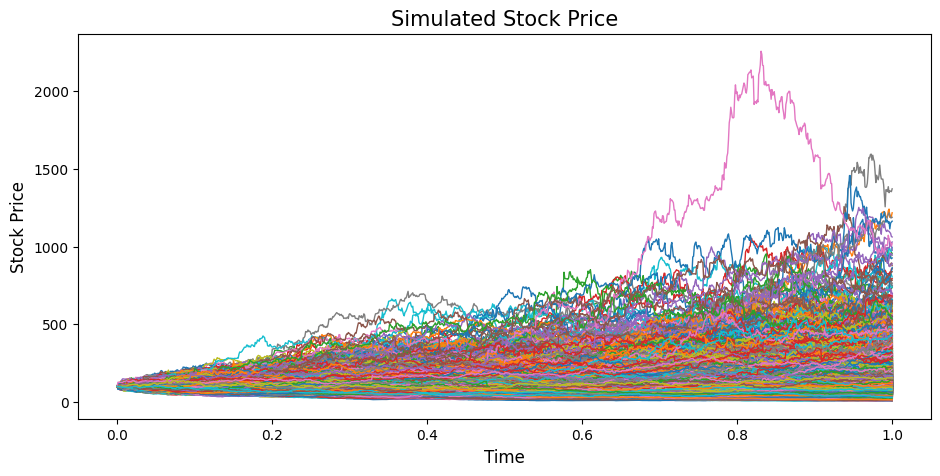

In [38]:
# plot stock prices
plt.figure(figsize=(11,5))
for sim in S:
    plt.plot(times, sim, linewidth=1)
plt.title('Simulated Stock Price', fontsize=15)
plt.ylabel('Stock Price', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.show()

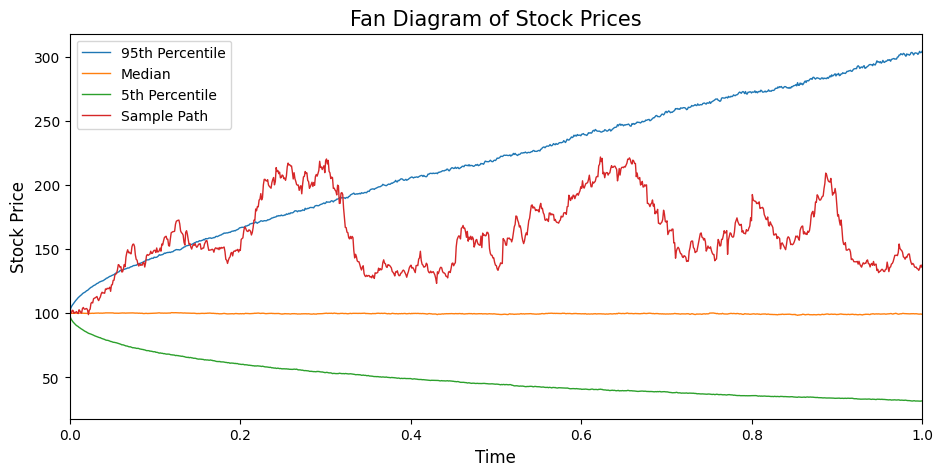

In [39]:
# set random seed for reproducibility 
np.random.seed(seed)
stock_index = np.random.randint(0, M-1)

# stock price bounds
top_five_percent = np.percentile(S,95,0)
bottom_five_percent = np.percentile(S,5,0)
median = np.percentile(S,50,0)

# plot stock price bounds
plt.figure(figsize=(11,5))
plt.plot(times, top_five_percent, linewidth=1, label='95th Percentile')
plt.plot(times,median, linewidth=1, label='Median')
plt.plot(times, bottom_five_percent, linewidth=1, label='5th Percentile')
plt.plot(times,S[stock_index,:], linewidth=1, label='Sample Path')
plt.xlim(0,1)
plt.legend()
plt.title('Fan Diagram of Stock Prices', fontsize=15)
plt.ylabel('Stock Price', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.show()

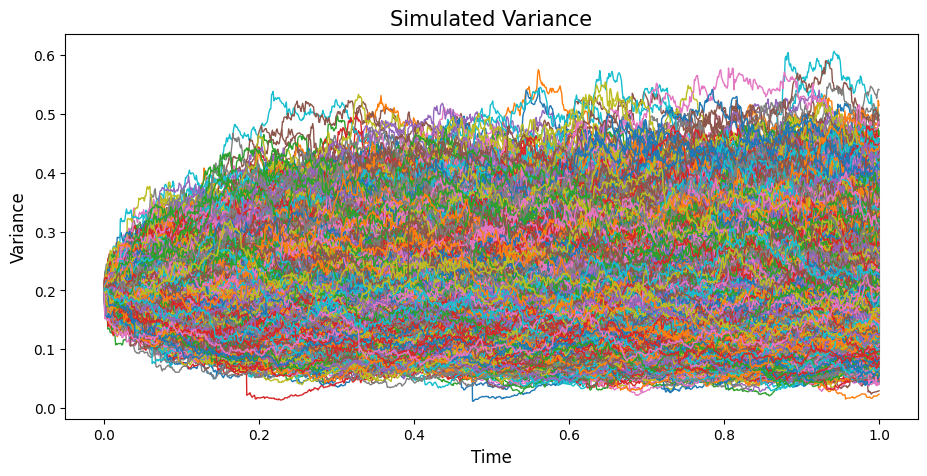

In [40]:
# plot variance
plt.figure(figsize=(11,5))
for sim in v:
    plt.plot(times, sim, linewidth=1)
plt.title('Simulated Variance', fontsize=15)
plt.ylabel('Variance', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.show()

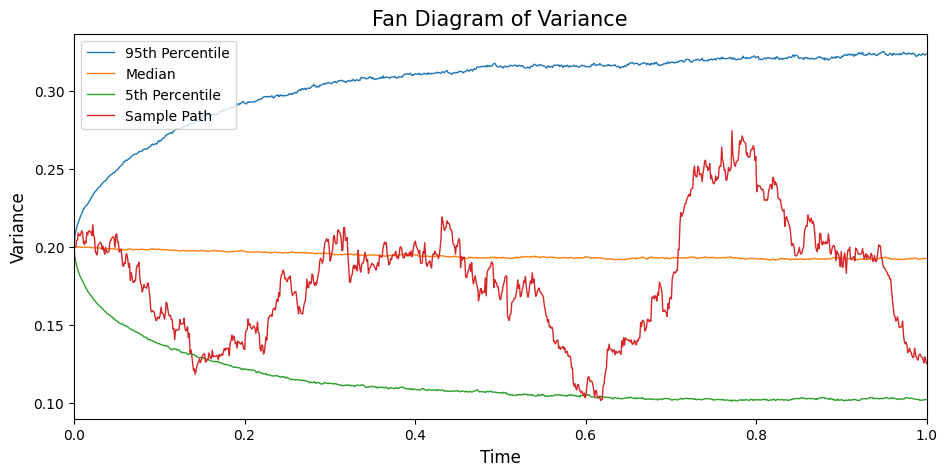

In [41]:
# set random seed for reproducibility 
np.random.seed(seed)
variance_index = np.random.randint(0, M-1)

# variance bounds
top_five_percent = np.percentile(v,95,0)
bottom_five_percent = np.percentile(v,5,0)
median = np.percentile(v,50,0)

# plot variance bounds
plt.figure(figsize=(11,5))
plt.plot(times, top_five_percent, linewidth=1, label='95th Percentile')
plt.plot(times,median, linewidth=1, label='Median')
plt.plot(times, bottom_five_percent, linewidth=1, label='5th Percentile')
plt.plot(times,v[variance_index,:], linewidth=1, label='Sample Path')
plt.xlim(0,1)
plt.legend()
plt.title('Fan Diagram of Variance', fontsize=15)
plt.ylabel('Variance', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.show()

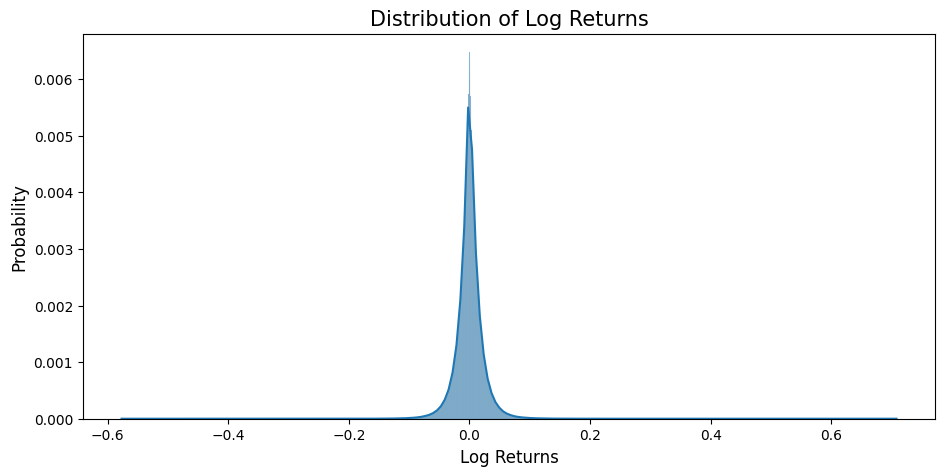

In [42]:
# plot disribution of log returns
log_returns = np.log(S[:,:-1]) - np.log(S[:,1:])
log_returns = log_returns.reshape(-1, M*(N - 1))[0]
plt.figure(figsize=(11,5))
sns.histplot(log_returns, kde=True, stat='probability')
plt.title('Distribution of Log Returns', fontsize=15)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Log Returns', fontsize=12)
plt.show()